# Capítulo 6 – Detección de Anomalías con Isolation Forest

En este capítulo se presenta el algoritmo **Isolation Forest**, una técnica no supervisada de detección de anomalías fundamentada en principios estadísticos y estructurales.  
Su principal fortaleza radica en que no requiere datos etiquetados ni un entrenamiento supervisado, lo que lo convierte en una opción idónea en contextos como el presente, donde no se dispone de información fiable que distinga entre observaciones normales y anómalas.

Isolation Forest se basa en la idea de que los puntos anómalos, al estar menos integrados en la distribución general de los datos, pueden **aislarse más fácilmente** a través de divisiones aleatorias del espacio de características.

## ¿Por qué Isolation Forest?

Las razones para emplear Isolation Forest en detección de anomalías incluyen:

- Modelo ligero, interpretable y rápido de entrenar, adecuado para exploración temprana.  
- No necesita etiquetas ni conocimiento experto previo.  
- Se aplica directamente sobre datos multivariantes sin grandes transformaciones.  
- Ha sido validado en múltiples entornos industriales, lo que respalda su aplicabilidad práctica.

## Intuición

Isolation Forest parte de la premisa:

> "Las anomalías son más fáciles de aislar que los puntos normales."

Mientras otros métodos buscan perfilar lo normal, iForest genera particiones aleatorias y mide lo fácil que resulta separar cada observación.  
Las anomalías, por su rareza y diferencias, requieren menos divisiones para quedar aisladas.

## Fundamento Teórico

El algoritmo construye múltiples **árboles binarios aleatorios** (*iTrees*):

- En cada nodo se selecciona aleatoriamente:
  - Una característica.
  - Un valor de corte dentro de su rango.
- El árbol se construye recursivamente hasta aislar un único punto o alcanzar una profundidad máxima.

### Profundidad de aislamiento

Cada observación recorre todos los árboles. La medida clave es la **profundidad media** necesaria para aislarla.  

- Anomalías → caminos cortos.  
- Normales → caminos más largos.  

El score de anomalía se define como:

$$
s(x, n) = 2^{-\frac{E(h(x))}{c(n)}}
$$

donde $E(h(x))$ es la profundidad media y $c(n)$ el valor esperado de la profundidad en un árbol con $n$ puntos.

### Interpretación del score

| Score $s(x)$ | Interpretación                |
|--------------|-------------------------------|
| ≈ 1          | Alta probabilidad de anomalía |
| ≈ 0.5        | Indefinido                    |
| ≈ 0          | Punto normal                  |

## Parámetros clave

- **n_estimators**: número de árboles (típico: 100–256).  
- **max_samples**: número de muestras para construir cada árbol.  
- **max_depth**: profundidad máxima del árbol.  
- **contamination**: fracción estimada de anomalías (en implementaciones prácticas).


## Implementación de un detector con Isolation Forest

Isolation Forest se implementa a partir de la idea de que las anomalías se aíslan con menos particiones.  
El modelo se construye mediante múltiples árboles aleatorios (*iTrees*), y el score de anomalía se calcula a partir de la profundidad media necesaria para aislar cada punto.

A continuación se muestran las piezas fundamentales de la implementación: funciones auxiliares, la definición del árbol base y finalmente la clase `IsolationForest` como detector.


In [13]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from modelos.datasets_to_parquet import load_project_parquets
from modelos.base import BaseAnomalyDetector

def harmonic_number(n):
    if n <= 1:
        return 0
    return np.log(n) + 0.5772156649

def c_factor(n):
    if n <= 1:
        return 0
    return 2 * harmonic_number(n - 1) - (2 * (n - 1) / n)

#### Comprobación rápida

A continuación se representan \( H(n) \) y \( c(n) \) para distintos tamaños de muestra.  
Esperamos crecimiento **logarítmico suave**, útil como normalizador del score.


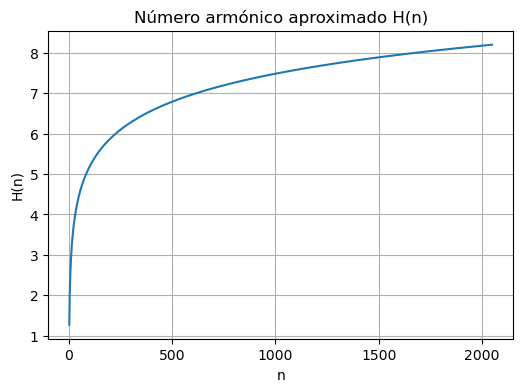

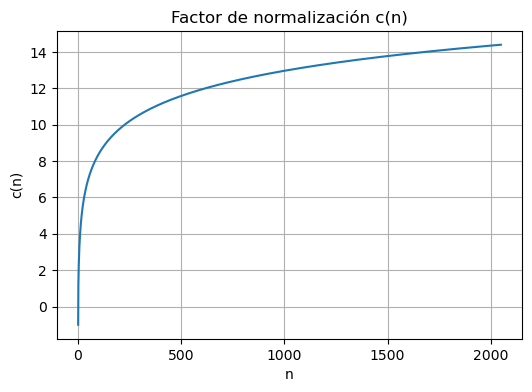

n	H(n)		c(n)
4	1.963510	1.851656
8	2.656657	3.296252
16	3.349804	4.695532
32	4.042952	6.084906
64	4.736099	7.471951
128	5.429246	8.858431
256	6.122393	10.244771
512	6.815540	11.631077
1024	7.508687	13.017374


In [14]:
# Rango de n para visualizar el crecimiento
ns = np.arange(2, 2049)  # desde 2 hasta 2048
H = np.array([harmonic_number(int(n)) for n in ns])
c = np.array([c_factor(int(n)) for n in ns])

# Gráfico 1: H(n)
plt.figure(figsize=(6, 4))
plt.plot(ns, H)
plt.xlabel("n")
plt.ylabel("H(n)")
plt.title("Número armónico aproximado H(n)")
plt.grid(True)
plt.show()

# Gráfico 2: c(n)
plt.figure(figsize=(6, 4))
plt.plot(ns, c)
plt.xlabel("n")
plt.ylabel("c(n)")
plt.title("Factor de normalización c(n)")
plt.grid(True)
plt.show()

# Tabla de referencia para n típicos de sample_size
ns_ref = [4, 8, 16, 32, 64, 128, 256, 512, 1024]
rows = [(n, harmonic_number(n), c_factor(n)) for n in ns_ref]

print("n\tH(n)\t\tc(n)")
for n, h, cf in rows:
    print(f"{n}\t{h:.6f}\t{cf:.6f}")


**Lectura de las figuras**

- Tanto \( H(n) \) como \( c(n) \) muestran un **crecimiento logarítmico**.  
- Esto significa que:
  - **Al inicio** (para valores pequeños de \( n \)) el incremento es muy rápido.  
  - **Después**, conforme \( n \) crece, el aumento se vuelve cada vez más lento y las curvas se van “aplanando”.  
- Gracias a este comportamiento, la **profundidad esperada de los árboles en Isolation Forest** no crece sin control con el tamaño de los datos, sino de manera moderada.  
- En la práctica, esto evita que el score de anomalía dependa directamente del tamaño del dataset y permite comparar resultados entre distintas configuraciones.



### Árbol de aislamiento (`iTree`)

Un `iTree` se construye recursivamente:
- En cada nodo se elige **una característica** al azar y un **valor de corte**.
- Se divide el conjunto en izquierda/derecha y se sigue recursivamente.
- Paramos si alcanzamos una **profundidad máxima** o si hay **≤ 1 muestra**.

En la implementación original de *Isolation Forest*, el corte se hace **uniformemente al azar** en el intervalo `[min, max]` de la característica elegida.  

En esta versión añadimos una **variante**: el corte se puede escoger como un valor aleatorio de entre los **valores reales de la muestra**.  
Esto introduce un cierto sesgo hacia zonas más densas de la distribución (una estimación muy simple de la densidad).


In [15]:
class iTree:
    def __init__(self, data, current_height=0, max_height=np.inf, split_selection_random=True):
        self.n_samples, self.n_features = data.shape
        self.left = None
        self.right = None
        self.split_attr = None
        self.split_value = None
        self.size = self.n_samples
        self.is_leaf = False

        # Criterios de parada
        if current_height >= max_height or self.n_samples <= 1:
            self.is_leaf = True
            return

        # Elegimos una característica al azar
        self.split_attr = np.random.randint(self.n_features)
        # Rango de esa característica
        col = data[:, self.split_attr]
        min_val, max_val = np.min(col), np.max(col)

        # Si no hay variación, hacemos hoja
        if min_val == max_val:
            self.is_leaf = True
            return

        # Valor de corte: uniforme en el rango o aleatorio entre valores observados
        if split_selection_random:
            self.split_value = float(np.random.uniform(min_val, max_val))
        else:
            self.split_value = float(np.random.choice(col))

        # División
        left_mask = col < self.split_value
        self.left = iTree(data[left_mask], current_height + 1, max_height, split_selection_random)
        self.right = iTree(data[~left_mask], current_height + 1, max_height, split_selection_random)


#### Comprobación rápida del nodo raíz

Generamos un dataset sencillo en 2D y entrenamos dos árboles:
1. Con **split uniforme en el rango** (versión original).
2. Con **split tomado de la muestra** (variante añadida).

Visualizamos el corte en cada caso para ver cómo cambia la partición.


Split uniforme:
 - Atributo: 0, Valor: 0.978
Split por muestra:
 - Atributo: 0, Valor: 0.083


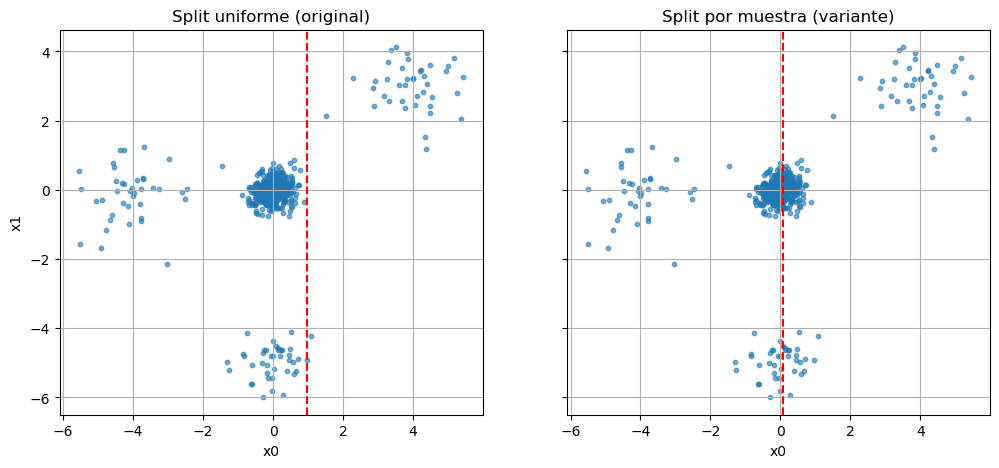

In [16]:
# Dataset 2D exagerado
rng = np.random.default_rng(42)

# Clúster muy denso en el centro
X_center = rng.normal(loc=[0, 0], scale=[0.3, 0.3], size=(400, 2))

# Algunos clústeres dispersos más alejados
X_out1 = rng.normal(loc=[-4, 0], scale=[0.8, 0.8], size=(40, 2))
X_out2 = rng.normal(loc=[4, 3], scale=[1.0, 0.5], size=(40, 2))
X_out3 = rng.normal(loc=[0, -5], scale=[0.6, 0.6], size=(40, 2))

# Concatenar todo
X_demo = np.vstack([X_center, X_out1, X_out2, X_out3])

# Árbol con split uniforme
tree_uniform = iTree(X_demo, current_height=0, max_height=1, split_selection_random=True)

# Árbol con split basado en muestra
tree_sample = iTree(X_demo, current_height=0, max_height=1, split_selection_random=False)

print("Split uniforme:")
print(f" - Atributo: {tree_uniform.split_attr}, Valor: {tree_uniform.split_value:.3f}")
print("Split por muestra:")
print(f" - Atributo: {tree_sample.split_attr}, Valor: {tree_sample.split_value:.3f}")

# Visualización
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

for ax, tree, title in zip(
    axes,
    [tree_uniform, tree_sample],
    ["Split uniforme (original)", "Split por muestra (variante)"]
):
    ax.scatter(X_demo[:,0], X_demo[:,1], s=10, alpha=0.6)
    if tree.split_attr == 0:
        ax.axvline(tree.split_value, ls="--", color="red")
    else:
        ax.axhline(tree.split_value, ls="--", color="red")
    ax.set_title(title)
    ax.set_xlabel("x0"); ax.grid(True)
axes[0].set_ylabel("x1")
plt.show()


**Lectura rápida**

- El **split uniforme** tiende a cortar en cualquier parte del rango, incluso en zonas donde apenas hay datos.  
- El **split basado en la muestra** coloca el corte en valores que realmente aparecen en los datos, lo que hace que la partición esté más alineada con la densidad observada, más amenudo.  

Esta variante no está en el algoritmo original, pero puede hacer que los árboles se ajusten un poco más a la distribución real.


#### Profundidad de camino (`path_length`)

Para evaluar lo “fácil” que es aislar un punto, calculamos la **longitud del camino** que recorre desde la raíz hasta que:
- llega a una **hoja**, y
- añadimos la **corrección** por el tamaño de la hoja con \( c(\text{size}) \) para ajustar la expectativa.

Implementamos `path_length` y lo probamos coloreando los puntos por su longitud de camino en un árbol poco profundo.


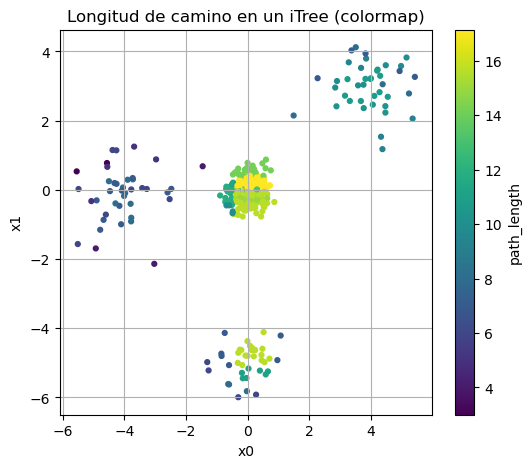

In [17]:
# Añadimos el método a la clase.
def _path_length(self, x, current_height=0):
    if self.is_leaf:
        return current_height + c_factor(self.size)
    if x[self.split_attr] < self.split_value:
        return self.left.path_length(x, current_height + 1)
    else:
        return self.right.path_length(x, current_height + 1)

setattr(iTree, "path_length", _path_length)

# Construimos un árbol con mayor profundidad para ver más variedad
tree_demo2 = iTree(X_demo, current_height=0, max_height=8, split_selection_random=True)

# Longitud de camino por punto
pl = np.array([tree_demo2.path_length(x) for x in X_demo])

# Visualización: puntos coloreados por longitud de camino
fig, ax = plt.subplots(figsize=(6, 5))
sc = ax.scatter(X_demo[:,0], X_demo[:,1], c=pl, s=12)
ax.set_title("Longitud de camino en un iTree (colormap)")
ax.set_xlabel("x0"); ax.set_ylabel("x1"); ax.grid(True)
cb = plt.colorbar(sc, ax=ax); cb.set_label("path_length")
plt.show()


**Lectura rápida**
- Puntos cercanos a regiones separables suelen requerir **menos splits** → menor `path_length`.
- Puntos integrados en zonas densas necesitan **más splits** → mayor `path_length`.
- Esta medida, normalizada por \( c(n) \) en el bosque, se transformará después en un **score de anomalía**.


## Implementación del detector Isolation Forest

`IsolationForest` ensambla múltiples `iTree` entrenados sobre **submuestras aleatorias** del conjunto de datos.  
Incorpora dos ideas clave:

- **Profundidad máxima** del árbol proporcional a `log2(sample_size)`, lo que controla el crecimiento.
- **Política de umbral**:
  - Si `contamination` es `None` → umbral fijo `τ = 0.5` (criterio clásico del score).
  - Si `contamination ∈ (0,1]` → umbral aprendido como el cuantil `1 - contamination` de los *scores* en entrenamiento.

Además, hereda la **política de corte** del `iTree`:
- `split_selection_random=True`: corte uniforme en `[min, max]` (original).
- `split_selection_random=False`: corte tomado de valores de la muestra (variante con sesgo hacia zonas densas).


In [18]:
import numpy as np
from modelos.base import BaseAnomalyDetector  # ya definida en el notebook anterior

class IsolationForest(BaseAnomalyDetector):
    """
    Detector Isolation Forest con dos políticas de split en cada nodo:
      - split_selection_random=True  -> corte uniforme en [min, max] (original)
      - split_selection_random=False -> corte elegido de la muestra (variante densa)

    Política de umbral:
      - contamination is None  -> τ = 0.5 (fijo)
      - contamination in (0,1] -> τ = quantile_{1-cont}(scores_train)
    """
    def __init__(self,
                 n_trees: int = 100,
                 sample_size: int = 256,
                 split_selection_random: bool = True,
                 contamination: float | None = None):
        self.n_trees = int(n_trees)
        self.sample_size = int(sample_size)
        self.split_selection_random = bool(split_selection_random)
        self.contamination = contamination  # None => τ=0.5 ; (0,1] => cuantil
        self.trees = []
        self.threshold_ = None  # se fijará en fit()

    # Dummy fit: solo guarda los datos
    def fit(self, X):
        X = np.asarray(X)
        self.trees = []          # en la versión real irían los árboles
        self.threshold_ = 0.5    # valor fijo por ahora
        return self

    # Dummy anomaly_score: devuelve ceros
    def anomaly_score(self, X, y=None):
        X = np.asarray(X)
        return np.zeros(len(X))

    # Dummy predict: compara scores con threshold_
    def predict(self, X, y=None):
        scores = self.anomaly_score(X)
        return (scores >= (self.threshold_ or 0.5)).astype(int)

### Método `fit`

Durante el ajuste:
1. Se calcula la **profundidad máxima** del árbol como `ceil(log2(max(sample_size, 2)))`.
2. Para cada uno de los `n_trees`:
   - Se extrae una **submuestra aleatoria** de tamaño `sample_size` (sin reemplazo si es menor que `n`, con reemplazo en caso contrario).
   - Se construye un `iTree` con la política de split elegida.
3. Se fija el **umbral de decisión** `τ`:
   - `τ = 0.5` si `contamination is None`.
   - `τ = quantile_{1-cont}(scores_train)` si se proporciona `contamination`.

In [19]:
def _fit(self, X):
    X = np.asarray(X)
    self.trees = []
    n = len(X)

    # Profundidad máxima ~ log2(sample_size)
    height_limit = int(np.ceil(np.log2(max(self.sample_size, 2))))

    # Construcción del bosque
    for _ in range(self.n_trees):
        if self.sample_size < n:
            idx = np.random.choice(n, self.sample_size, replace=False)
        else:
            idx = np.random.choice(n, self.sample_size, replace=True)
        sample = X[idx]
        tree = iTree(sample,
                        current_height=0,
                        max_height=height_limit,
                        split_selection_random=self.split_selection_random)
        self.trees.append(tree)

    # Política de umbral
    if self.contamination is None:
        self.threshold_ = 0.5
    else:
        scores_train = self.anomaly_score(X)
        q = float(1.0 - self.contamination)
        q = min(max(q, 0.0), 1.0)  # seguridad
        self.threshold_ = np.quantile(scores_train, q)
    return self

setattr(IsolationForest, "fit", _fit)


#### Comprobación de `fit` con datos de juguete

Usamos el dataset 2D exagerado de antes para entrenar rápidamente y ver:
- Número de árboles construidos.
- Profundidad máxima empleada.
- Umbral resultante.

In [20]:
# Reutilizamos X_demo creado anteriormente (clúster central denso + grupos periféricos)
forest = IsolationForest(n_trees=20, sample_size=128, split_selection_random=False)
forest.fit(X_demo)

print("Árboles construidos:", len(forest.trees))
print("Umbral (threshold_):", f"{forest.threshold_:.4f}" if forest.threshold_ is not None else None)

# Podemos inferir la profundidad máxima a partir del primer árbol entrenado
# (no se almacena explícitamente; la computamos de nuevo para mostrarla)
height_limit = int(np.ceil(np.log2(max(forest.sample_size, 2))))
print("Profundidad máxima (estimada):", height_limit)


Árboles construidos: 20
Umbral (threshold_): 0.5000
Profundidad máxima (estimada): 7


### Método `anomaly_score`

El **score de anomalía** mide lo fácil que es aislar un punto:

$$
s(x) = 2^{-\frac{E(h(x))}{c(n)}}
$$

- $E(h(x))$: longitud media del camino hasta aislar $x$ en todos los árboles.
- $c(n)$: factor de normalización que ajusta la profundidad esperada en un árbol aleatorio de tamaño $n$.

Interpretación:
- **Valores cercanos a 1** → puntos aislados rápidamente → posibles anomalías.
- **Valores bajos** → puntos normales, requieren más divisiones.


In [21]:
def _anomaly_score(self, X):
        X = np.asarray(X)
        scores = np.zeros(len(X), dtype=float)
        denom = c_factor(self.sample_size)
        if denom <= 0:
            denom = 1.0  # seguridad numérica
        for i, x in enumerate(X):
            path_lengths = np.array([t.path_length(x) for t in self.trees], dtype=float)
            E_h = np.mean(path_lengths)
            scores[i] = 2 ** (-E_h / denom)
        return scores

setattr(IsolationForest, "anomaly_score", _anomaly_score)

#### Visualización de los *scores*

Probamos el método con el dataset sintético `X_demo`:
- Mostramos un histograma de los scores.
- Visualizamos en 2D coloreando cada punto según su score de anomalía.


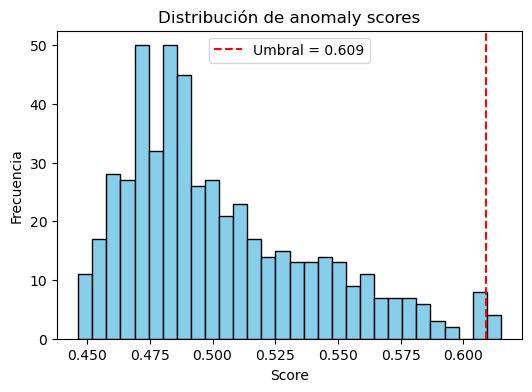

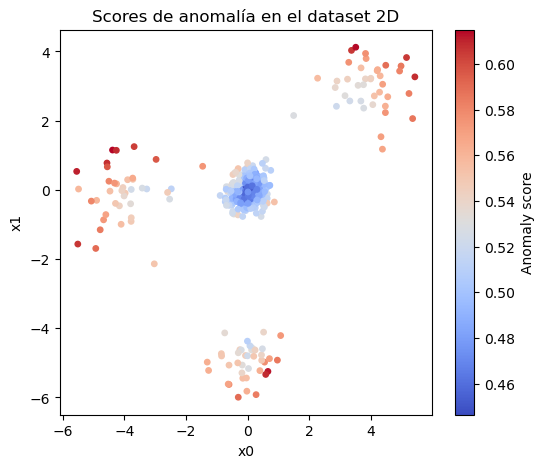

In [22]:
# Entrenamos de nuevo el bosque sobre X_demo
forest = IsolationForest(n_trees=50, sample_size=128, split_selection_random=False, contamination=0.01)
forest.fit(X_demo)

# Calculamos los scores
scores = forest.anomaly_score(X_demo)

# Histograma de scores
plt.figure(figsize=(6,4))
plt.hist(scores, bins=30, color="skyblue", edgecolor="black")
plt.axvline(forest.threshold_, color="red", linestyle="--", label=f"Umbral = {forest.threshold_:.3f}")
plt.title("Distribución de anomaly scores")
plt.xlabel("Score")
plt.ylabel("Frecuencia")
plt.legend()
plt.show()

# Scatter plot coloreado por score
plt.figure(figsize=(6,5))
plt.scatter(X_demo[:,0], X_demo[:,1], c=scores, cmap="coolwarm", s=15)
plt.colorbar(label="Anomaly score")
plt.title("Scores de anomalía en el dataset 2D")
plt.xlabel("x0")
plt.ylabel("x1")
plt.show()


### Método `predict`

El método `predict` transforma los *scores* en etiquetas binarias:
- **1 = anomalía** si el score ≥ umbral.
- **0 = normal** en caso contrario.

El umbral `τ` puede fijarse de dos formas:
- Automáticamente en `fit()` (dependiendo de `contamination`).
- Manualmente pasando un valor al argumento `threshold` de `predict`.


In [23]:
def _predict(self, X, threshold=None):
        X = np.asarray(X)
        tau = threshold if threshold is not None else self.threshold_
        return (self.anomaly_score(X) >= tau).astype(int)

setattr(IsolationForest, "predict", _predict)

#### Predicciones en el dataset sintético

Aplicamos `predict` a `X_demo` y visualizamos:
- Los puntos normales frente a los detectados como anómalos.

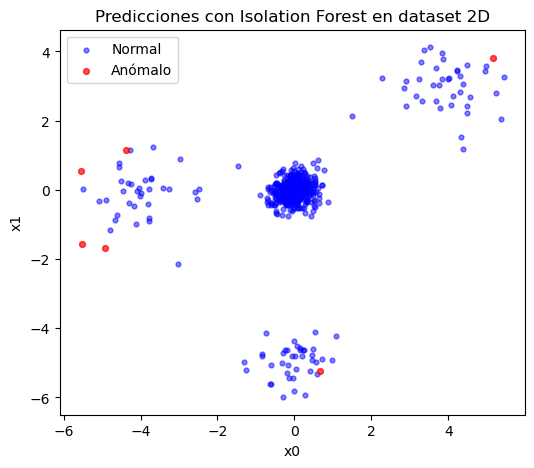

In [24]:
forest = IsolationForest(n_trees=50, sample_size=128, split_selection_random=False, contamination=0.01)
forest.fit(X_demo)

y_pred = forest.predict(X_demo)

# Scatter mostrando normales vs anomalías
plt.figure(figsize=(6,5))
plt.scatter(X_demo[y_pred==0,0], X_demo[y_pred==0,1], c="blue", s=12, alpha=0.5, label="Normal")
plt.scatter(X_demo[y_pred==1,0], X_demo[y_pred==1,1], c="red", s=18, alpha=0.7, label="Anómalo")
plt.title("Predicciones con Isolation Forest en dataset 2D")
plt.xlabel("x0")
plt.ylabel("x1")
plt.legend()
plt.show()

## Conclusión

Isolation Forest nos muestra que, a veces, **la simplicidad es el mejor aliado** en la detección de anomalías.  
Basado únicamente en aislar puntos de forma aleatoria, consigue un equilibrio interesante entre eficiencia, interpretabilidad y capacidad de generalización.  

No obstante, su carácter aleatorio y la ausencia de un modelado explícito de la frontera entre lo normal y lo anómalo hacen que, en ciertos escenarios, pueda resultar insuficiente.  
Precisamente por ello, en el próximo capítulo exploraremos un enfoque de naturaleza distinta: **One-Class SVM**, un modelo que, en lugar de buscar el aislamiento, se centra en **aprender la frontera del espacio normal** y detectar las observaciones que se desvían de ella.  

Este contraste entre técnicas complementarias enriquecerá nuestra visión sobre cómo abordar el problema de la detección de anomalías desde diferentes ángulos.


---

## Referencias

- Liu, Fei Tony, Kai Ming Ting, and Zhi-Hua Zhou.  
**"Isolation forest."** *2008 Eighth IEEE International Conference on Data Mining*. IEEE, 2008.  

- Liu, Fei Tony, Kai Ming Ting, and Zhi-Hua Zhou.  
**"Isolation-based anomaly detection."** *ACM Transactions on Knowledge Discovery from Data (TKDD)* 6.1 (2012): 1–39.  

- Hariri, Sahar, Matias R. Carrasco Kind, and Robert J. Brunner.  
**"Extended isolation forest."** *IEEE Transactions on Knowledge and Data Engineering* 33.4 (2021): 1479–1489.  
